# Лабораторная работа: Классификация (LoanApproved)

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Настройки окружения
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
sns.set_theme(style='whitegrid', context='talk')

# Глобальные константы
SEED = 42
VAL_FRAC = 0.2
CLIP_LIMITS = (0.01, 0.99)
CORRELATION_LIMIT = 0.995

## 1. Загрузка и первичная обработка

Размерность train: (11017, 35), test: (5000, 35)
Размер после очистки: 10000 (удалено 1017)
Баланс классов: 51.26% одобрено


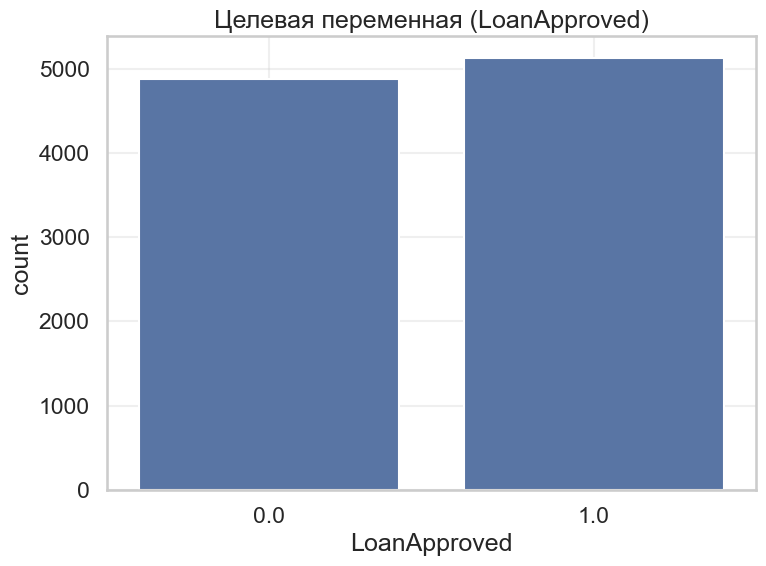

In [2]:
def load_and_clean_target(train_path, test_path):
    """Загружает данные и проводит очистку целевой переменной."""
    raw_train = pd.read_csv(train_path)
    raw_test = pd.read_csv(test_path)

    print(f"Размерность train: {raw_train.shape}, test: {raw_test.shape}")

    # Удаление пропусков и дубликатов
    initial_len = len(raw_train)
    df = raw_train.dropna(subset=['LoanApproved'])
    df = df.drop_duplicates()
    
    print(f"Размер после очистки: {len(df)} (удалено {initial_len - len(df)})")
    return df, raw_test

data_train, data_test = load_and_clean_target('data/train_c.csv', 'data/test_c.csv')

# Визуализация распределения
print(f"Баланс классов: {data_train['LoanApproved'].mean():.2%} одобрено")
plt.figure(figsize=(8, 6))
sns.countplot(x='LoanApproved', data=data_train)
plt.title('Целевая переменная (LoanApproved)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Предобработка признаков

In [3]:
def preprocess_features(df_train, df_test):
    """Базовая предобработка: разделение, кодирование, импутация."""
    target = df_train['LoanApproved'].copy().astype(int)
    
    # Удаление служебных столбцов
    feat_train = df_train.drop(columns=['ApplicationDate', 'LoanApproved'], errors='ignore')
    feat_test = df_test.drop(columns=['ID', 'ApplicationDate'], errors='ignore')

    # One-Hot Encoding
    cat_columns = feat_train.select_dtypes(include=['object']).columns
    feat_train = pd.get_dummies(feat_train, columns=cat_columns, drop_first=True)
    feat_test = pd.get_dummies(feat_test, columns=cat_columns, drop_first=True)

    # Выравнивание столбцов
    missing_cols = set(feat_train.columns) - set(feat_test.columns)
    for c in missing_cols:
        feat_test[c] = 0
    feat_test = feat_test[feat_train.columns]

    # Обработка пропусков и выбросов
    for col in feat_train.columns:
        # Заполнение медианой
        if feat_train[col].isnull().any():
            median_val = feat_train[col].median()
            feat_train[col].fillna(median_val, inplace=True)
            feat_test[col].fillna(median_val, inplace=True)
        
        # Клиппинг числовых признаков
        if feat_train[col].dtype in ['float64', 'int64']:
            lower = feat_train[col].quantile(CLIP_LIMITS[0])
            upper = feat_train[col].quantile(CLIP_LIMITS[1])
            feat_train[col] = feat_train[col].clip(lower=lower, upper=upper)
            feat_test[col] = feat_test[col].clip(lower=lower, upper=upper)
            
    return feat_train, feat_test, target

feat_train, feat_test, target_train = preprocess_features(data_train, data_test)
print(f"Признаков после кодирования: {feat_train.shape[1]}")

Признаков после кодирования: 44


## 3. Отбор признаков по корреляции

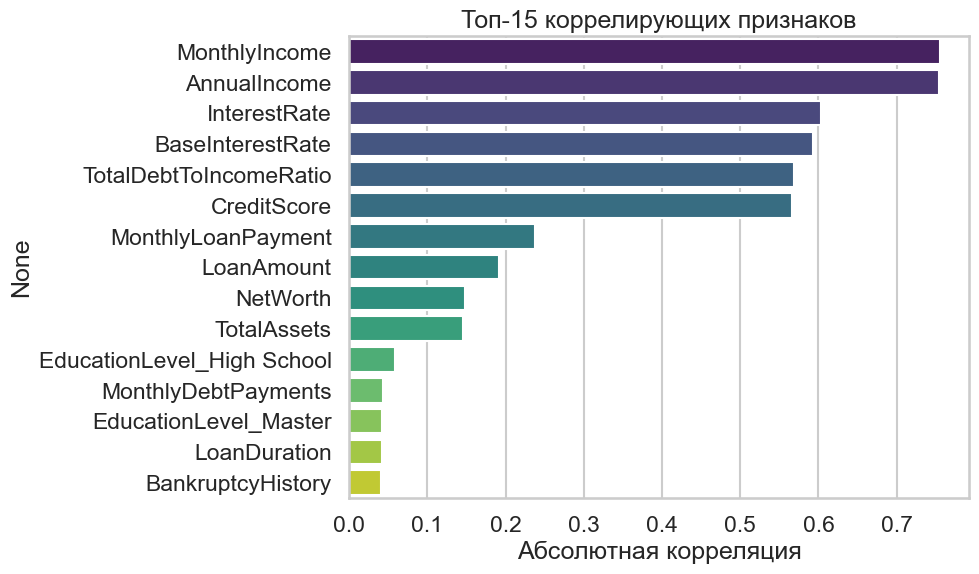

In [4]:
# Вычисляем корреляции с целевой переменной
corrs = feat_train.corrwith(target_train).abs().sort_values(ascending=False)

# Группы признаков для генерации
top_vars = {
    'sq': corrs.index[:25].tolist(),    # Квадраты
    'cb': corrs.index[:15].tolist(),    # Кубы
    'p4': corrs.index[:5].tolist(),     # 4-я степень
    'pairs': corrs.index[:12].tolist(), # Парные взаимодействия
    'triplets': corrs.index[:5].tolist(), # Тройные взаимодействия
    'sqrt': corrs.index[:10].tolist(),  # Корни
    'inv': corrs.index[:7].tolist()     # Обратные величины
}

# Визуализация топа
plt.figure(figsize=(8, 6))
sns.barplot(x=corrs.head(15).values, y=corrs.head(15).index, palette='viridis')
plt.title('Топ-15 коррелирующих признаков')
plt.xlabel('Абсолютная корреляция')
plt.show()

## 4. Конструирование признаков (Feature Engineering)

In [5]:
def generate_advanced_features(base_df, feature_groups):
    """Генерация полиномиальных и доменных признаков."""
    new_data = {}
    
    # Полиномиальные признаки
    for col in feature_groups['sq']:
        new_data[f"{col}_sq"] = base_df[col] ** 2
        
    for col in feature_groups['cb']:
        new_data[f"{col}_cube"] = base_df[col] ** 3
        
    for col in feature_groups['p4']:
        new_data[f"{col}_pow4"] = base_df[col] ** 4
        
    # Взаимодействия (Interactions)
    pairs = feature_groups['pairs']
    for i in range(len(pairs)):
        for j in range(i + 1, len(pairs)):
            c1, c2 = pairs[i], pairs[j]
            new_data[f"{c1}_x_{c2}"] = base_df[c1] * base_df[c2]
            
    triplets = feature_groups['triplets']
    for i in range(len(triplets)):
        for j in range(i + 1, len(triplets)):
            for k in range(j + 1, len(triplets)):
                c1, c2, c3 = triplets[i], triplets[j], triplets[k]
                new_data[f"{c1}_x_{c2}_x_{c3}"] = base_df[c1] * base_df[c2] * base_df[c3]
                
    # Математические трансформации
    log_candidates = ['AnnualIncome', 'MonthlyIncome', 'LoanAmount', 'TotalAssets', 
                      'NetWorth', 'CreditScore', 'SavingsAccountBalance', 'CheckingAccountBalance']
    
    for col in log_candidates:
        if col in base_df.columns:
            new_data[f"{col}_log"] = np.log1p(np.maximum(base_df[col], 0))
            
    for col in feature_groups['sqrt']:
        new_data[f"{col}_sqrt"] = np.sqrt(np.abs(base_df[col]))
        
    for col in feature_groups['inv']:
        new_data[f"{col}_inv"] = 1 / (np.abs(base_df[col]) + 1)
        
    # Доменные (финансовые) отношения
    def safe_col(name): return base_df[name] if name in base_df.columns else pd.Series(0, index=base_df.index)
    
    ann_inc = safe_col('AnnualIncome')
    mon_inc = safe_col('MonthlyIncome')
    
    new_data['income_consistency'] = ann_inc / (mon_inc * 12 + 1)
    new_data['credit_per_age'] = safe_col('CreditScore') / (safe_col('Age') + 1)
    new_data['loan_to_income'] = safe_col('LoanAmount') / (ann_inc + 1)
    new_data['liability_ratio'] = safe_col('TotalLiabilities') / (safe_col('TotalAssets') + 1)
    new_data['wealth_per_age'] = safe_col('NetWorth') / (safe_col('Age') + 1)
    new_data['payment_to_income'] = safe_col('MonthlyLoanPayment') / (mon_inc + 1)

    return pd.DataFrame(new_data).reset_index(drop=True)

# Применяем генерацию
print("Генерация признаков...")
extra_train = generate_advanced_features(feat_train, top_vars)
extra_test = generate_advanced_features(feat_test, top_vars)

feat_train_full = pd.concat([feat_train.reset_index(drop=True), extra_train], axis=1)
feat_test_full = pd.concat([feat_test.reset_index(drop=True), extra_test], axis=1)

print(f"Всего признаков: {feat_train_full.shape[1]}")

Генерация признаков...
Всего признаков: 196


## 5. Постобработка и очистка

In [6]:
def clean_generated_features(df_tr, df_te, target, corr_threshold=0.995):
    """Удаление inf, nan и мультиколлинеарных признаков."""
    # Замена бесконечностей и пропусков
    df_tr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_te.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    for col in df_tr.columns:
        if df_tr[col].isnull().any():
            med = df_tr[col].median()
            med = 0 if pd.isna(med) else med
            df_tr[col].fillna(med, inplace=True)
            df_te[col].fillna(med, inplace=True)
            
    # Удаление мультиколлинеарности
    corr_matrix = df_tr.corr()
    drop_set = set()
    cols = corr_matrix.columns
    
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                col_a, col_b = cols[i], cols[j]
                corr_a = abs(df_tr[col_a].corr(target))
                corr_b = abs(df_tr[col_b].corr(target))
                drop_set.add(col_b if corr_a >= corr_b else col_a)
    
    if drop_set:
        print(f"Удалено {len(drop_set)} мультиколлинеарных признаков")
        df_tr.drop(columns=drop_set, inplace=True)
        df_te.drop(columns=drop_set, inplace=True)
        
    return df_tr, df_te

feat_train_clean, feat_test_clean = clean_generated_features(
    feat_train_full, feat_test_full, target_train, CORRELATION_LIMIT
)

print(f"Итоговое количество признаков: {feat_train_clean.shape[1]}")

Удалено 39 мультиколлинеарных признаков
Итоговое количество признаков: 157


## 6. Масштабирование и Моделирование

[I 2025-11-28 04:11:25,652] A new study created in memory with name: no-name-7cd18383-c9a4-4c6f-b149-0cf37a757247


train: 8000, validation: 2000
Запуск оптимизации Optuna...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-28 04:11:26,091] Trial 0 finished with value: 0.9769951219512194 and parameters: {'model': 'RandomForest', 'rf_n_estimators': 200, 'rf_max_depth': 5, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 1}. Best is trial 0 with value: 0.9769951219512194.
[I 2025-11-28 04:11:42,670] Trial 1 finished with value: 0.9526363977485929 and parameters: {'model': 'LogisticRegression', 'lr_C': 0.001267425589893723, 'lr_penalty': 'l1'}. Best is trial 0 with value: 0.9769951219512194.
[I 2025-11-28 04:11:59,294] Trial 2 finished with value: 0.9545535959974984 and parameters: {'model': 'LogisticRegression', 'lr_C': 0.033205591037519584, 'lr_penalty': 'l1'}. Best is trial 0 with value: 0.9769951219512194.
[I 2025-11-28 04:11:59,668] Trial 3 finished with value: 0.9782654158849281 and parameters: {'model': 'RandomForest', 'rf_n_estimators': 123, 'rf_max_depth': 9, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 8}. Best is trial 3 with value: 0.9782654158849281.
[I 2025-11-28 04:12:30,767]

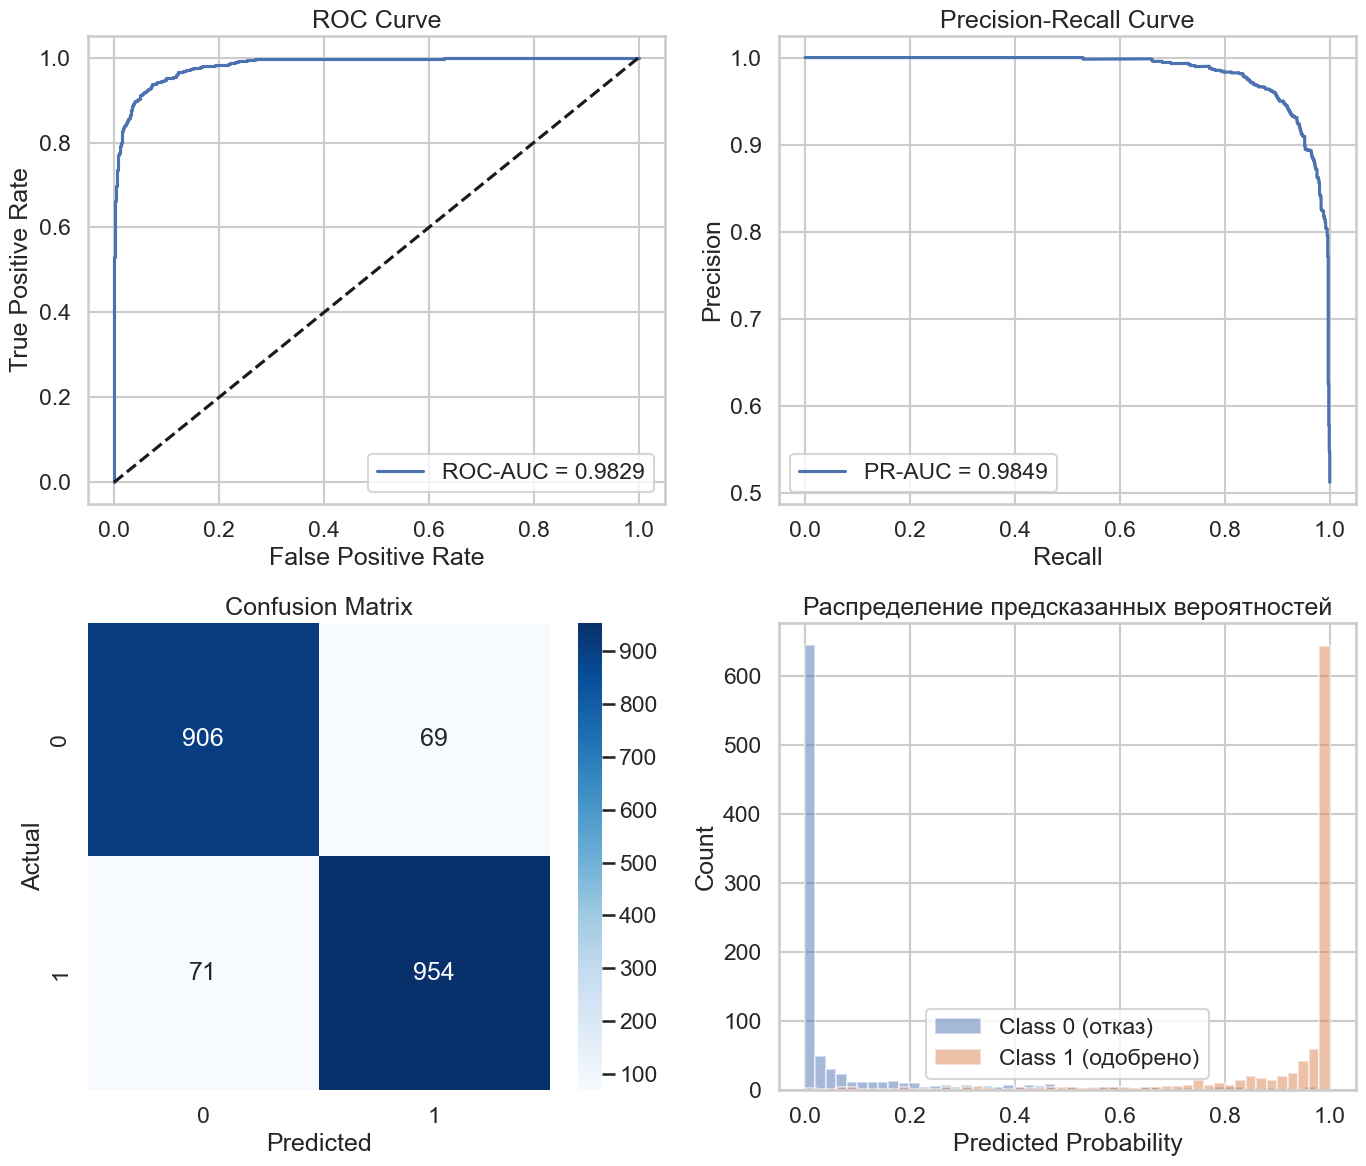

In [7]:
# Масштабирование
scaler = RobustScaler()
X_scaled = scaler.fit_transform(feat_train_clean)
X_test_scaled = scaler.transform(feat_test_clean)

# Разделение на валидацию
X_tr, X_val, y_tr, y_val = train_test_split(
    X_scaled, target_train, test_size=VAL_FRAC, random_state=SEED, stratify=target_train
)

print(f"train: {X_tr.shape[0]}, validation: {X_val.shape[0]}")

# Оптимизация гиперпараметров с Optuna
def objective(trial):
    model_name = trial.suggest_categorical('model', ['LogisticRegression', 'RandomForest', 'GradientBoosting'])
    
    if model_name == 'LogisticRegression':
        C = trial.suggest_float('lr_C', 0.001, 100, log=True)
        penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2'])
        solver = 'saga' if penalty == 'l1' else 'lbfgs'
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=2000, random_state=SEED)
    
    elif model_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
        max_depth = trial.suggest_int('rf_max_depth', 3, 20)
        min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 10)
        model = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth,
            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
            random_state=SEED, n_jobs=-1
        )
    
    else:  # GradientBoosting
        n_estimators = trial.suggest_int('gb_n_estimators', 50, 300)
        max_depth = trial.suggest_int('gb_max_depth', 2, 10)
        learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.3, log=True)
        min_samples_split = trial.suggest_int('gb_min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('gb_min_samples_leaf', 1, 10)
        subsample = trial.suggest_float('gb_subsample', 0.6, 1.0)
        model = GradientBoostingClassifier(
            n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
            subsample=subsample, random_state=SEED
        )
    
    model.fit(X_tr, y_tr)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

print("Запуск оптимизации Optuna...")
sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20, show_progress_bar=True)

print(f"\nЛучший ROC-AUC: {study.best_value:.4f}")
print(f"Лучшие параметры: {study.best_params}")

# Обучение лучшей модели
best_params = study.best_params
model_name = best_params['model']

if model_name == 'LogisticRegression':
    best_model = LogisticRegression(
        C=best_params['lr_C'], 
        penalty=best_params['lr_penalty'],
        solver='saga' if best_params['lr_penalty'] == 'l1' else 'lbfgs',
        max_iter=2000, random_state=SEED
    )
elif model_name == 'RandomForest':
    best_model = RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params['rf_min_samples_leaf'],
        random_state=SEED, n_jobs=-1
    )
else:
    best_model = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        max_depth=best_params['gb_max_depth'],
        learning_rate=best_params['gb_learning_rate'],
        min_samples_split=best_params['gb_min_samples_split'],
        min_samples_leaf=best_params['gb_min_samples_leaf'],
        subsample=best_params['gb_subsample'],
        random_state=SEED
    )

best_model.fit(X_tr, y_tr)

# Оценка качества
y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
y_pred_val = best_model.predict(X_val)

roc_auc = roc_auc_score(y_val, y_pred_proba_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)

# PR-AUC calculation
precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_proba_val)
pr_auc = auc(recall_curve, precision_curve)

print("\n" + "-"*30)
print("Результаты валидации:")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")
print("-" * 30)

print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

# Визуализация результатов валидации
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ROC кривая
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_val)
axes[0, 0].plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}')
axes[0, 0].plot([0, 1], [0, 1], 'k--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True)

# PR кривая
axes[0, 1].plot(recall_curve, precision_curve, label=f'PR-AUC = {pr_auc:.4f}')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix')

# Распределение вероятностей
axes[1, 1].hist(y_pred_proba_val[y_val == 0], bins=50, alpha=0.5, label='Class 0 (отказ)')
axes[1, 1].hist(y_pred_proba_val[y_val == 1], bins=50, alpha=0.5, label='Class 1 (одобрено)')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Распределение предсказанных вероятностей')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 7. Финальный прогноз

Финальное обучение на всех данных...
Прогноз: min=0.0000, max=1.0000, mean=0.5194


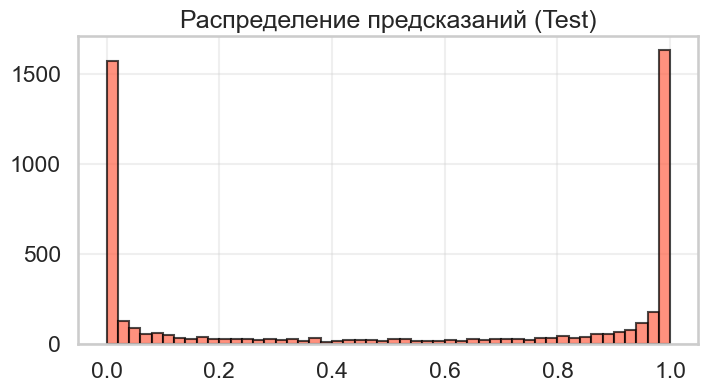

Файл submission_classification.csv успешно создан.


In [8]:
# Обучение на всех данных
print("Финальное обучение на всех данных...")
best_model.fit(X_scaled, target_train)
final_preds_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Анализ прогноза
print(f"Прогноз: min={final_preds_proba.min():.4f}, max={final_preds_proba.max():.4f}, mean={final_preds_proba.mean():.4f}")

plt.figure(figsize=(8, 4))
plt.hist(final_preds_proba, bins=50, color='tomato', edgecolor='black', alpha=0.7)
plt.title('Распределение предсказаний (Test)')
plt.grid(True, alpha=0.3)
plt.show()

# Сохранение результата
submission = pd.DataFrame({
    'ID': data_test['ID'],
    'LoanApproved': final_preds_proba
})
submission.to_csv('submission_classification.csv', index=False)
print("Файл submission_classification.csv успешно создан.")